In [1]:
import csv
import os
import timeit

import argparse
import h5py
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ufl

from dolfinx import cpp, fem, io, mesh
from mpi4py import MPI
from petsc4py import PETSc
from scipy import interpolate

import commons, configs, constants

markers = commons.SurfaceMarkers()

In [2]:
Lz = 5
areas = {
    1: 100,
    6: 98.41,
    11: 36.38,
    16: 6.30,
    22: 0.45,
}
data_dir = f"mesh/study_2/test6/470-470-{Lz}_000-000-000/"

## Left Boundary

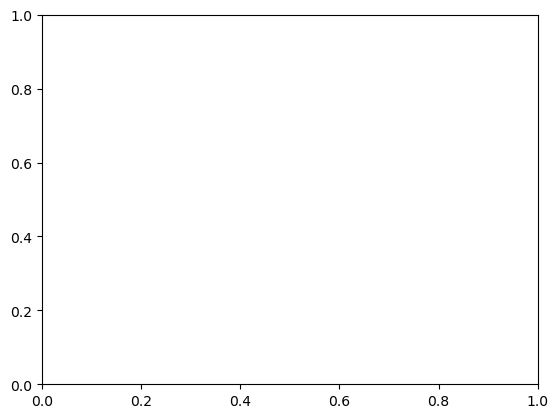

In [3]:
limits = {
    1: [58.8, 59],
    5: [11, 15],
    50: [0, 15],
    100: [0, 10],
    200: [0, 25],
}
for Lz in [1, 5, 50, 100]:
    fig, ax = plt.subplots()
    for img_id in [6, 11, 16, 22]:
        data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf.csv")
        df = pd.read_csv(data_path)
        ax.plot(np.abs(df['i [A/m2]']), df['p_left'], label=f'{areas[img_id]} %', linewidth=1)
    
    ax.set_xlabel('$i$ $[Am^{-2}]$', fontdict={'fontsize': 'xx-large'})
    ax.set_ylabel('active area', fontdict={'fontsize': 'xx-large'})
    ax.set_title(f'$L_z$ = {800/470 * Lz:.1f} $\mu$m')
    ax.set_box_aspect(1)
    ax.set_ylim([0, 1])
    ax.set_xlim(limits[Lz])
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'figures/study_2_cdf_{Lz}.png', dpi=1200)
    plt.close()

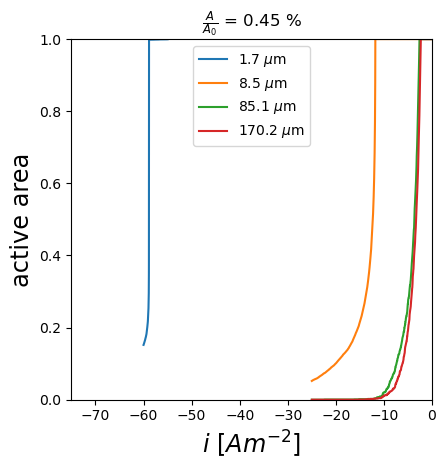

In [4]:
ll = 0
ul = 75

for img_id in [6, 11, 16, 22]:
    fig, ax = plt.subplots()
    for Lz in [1, 5, 50, 100]:
        data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf.csv")
        df = pd.read_csv(data_path)
        ax.plot(np.abs(df['i [A/m2]']), df['p_left'], label=f'{800/470*Lz:.1f} $\mu$m')

    ax.set_xlabel('$i$ $[Am^{-2}]$', fontdict={'fontsize': 'xx-large'})
    ax.set_ylabel('active area', fontdict={'fontsize': 'xx-large'})
    ax.set_title(r"$\frac{A}{A_0}$ = " + f"{areas[img_id]} %")
    ax.set_box_aspect(1)
    ax.set_ylim([0, 1])
    ax.set_xlim([ll, ul])
    ax.legend(loc='upper center')
    plt.tight_layout()
    plt.savefig(f'figures/study_2_cdf-id{img_id}.png', dpi=1200)
    plt.close()

### Derivative of Current Density at Electrode/Solid Electrolyte Interface

In [5]:
rho_li = 534  # [kg/m3]
MW_li = 6.94e-3  # [kg/mol]
E_shear = 2.83e9  # [N/m2]
E_young = 7.82e9  # [N/m2]
F_farad = 96485  # [C/mol]
L0 = 1e-6  # initial lithium thickness [m]

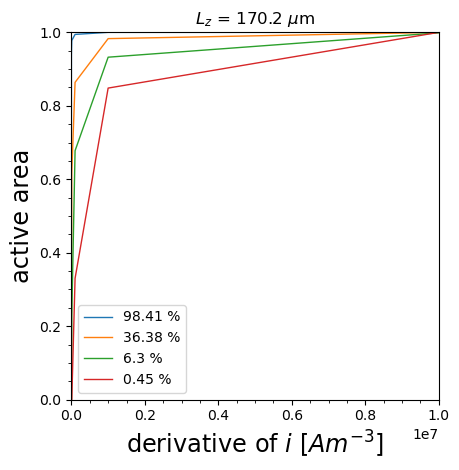

In [6]:
limits = {
    1: [-59, -58.8],
    5: [-15, -11],
    50: [-15, 0],
    100: [-10, 0],
    200: [0, 1e7],
}
Lz = 100
fig, ax = plt.subplots()
for img_id in [6, 11, 16, 22]:
    data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf_grad_cd.csv")
    df = pd.read_csv(data_path)
    ax.plot(df['i [A/m2]'], df['p_left'], label=f'{areas[img_id]} %', linewidth=1)

ax.set_xlabel('derivative of $i$ $[Am^{-3}]$', fontdict={'fontsize': 'xx-large'})
ax.set_ylabel('active area', fontdict={'fontsize': 'xx-large'})
ax.set_title(f'$L_z$ = {800/470 * Lz:.1f} $\mu$m')
ax.set_box_aspect(1)
ax.set_ylim([0, 1])
ax.set_xlim([0, 1e7])
ax.minorticks_on();
ax.legend()
plt.tight_layout()
plt.savefig(f'figures/study_2_grad_cd_cdf_{Lz}.png', dpi=1200)

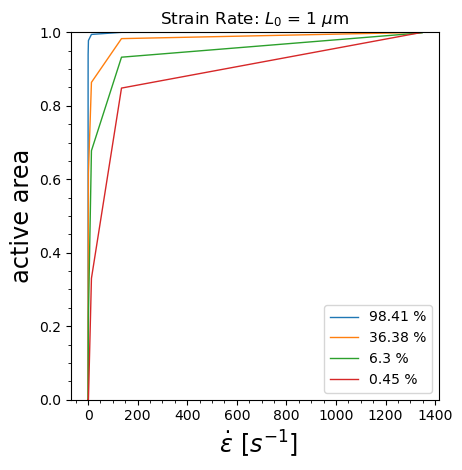

In [7]:
limits = {
    1: [-59, -58.8],
    5: [-15, -11],
    50: [-15, 0],
    100: [-10, 0],
    200: [0, 1e7],
}
Lz = 100
fig, ax = plt.subplots()
for img_id in [6, 11, 16, 22]:
    data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf_grad_cd.csv")
    df = pd.read_csv(data_path)
    ax.plot(df['i [A/m2]'] * (MW_li) / (F_farad * rho_li * L0), df['p_left'], label=f'{areas[img_id]} %', linewidth=1)

ax.set_xlabel(' $\dot{\epsilon}$ [$s^{-1}$]', fontdict={'fontsize': 'xx-large'})
ax.set_ylabel('active area', fontdict={'fontsize': 'xx-large'})
ax.set_title(f'Strain Rate: $L_0$ = {L0 * 1e6:.0f} $\mu$m')
ax.set_box_aspect(1)
ax.set_ylim([0, 1])
# ax.set_xlim([0, 1e7])
ax.minorticks_on();
ax.legend()
plt.tight_layout()
plt.savefig(f'figures/study_2_strain_rate_{Lz}.png', dpi=1200)

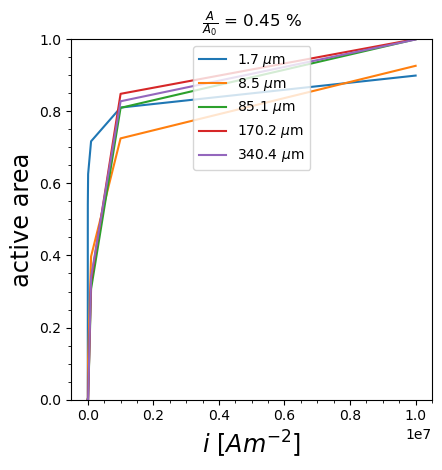

In [12]:
ul = 0
ll = -75
img_id = 22

fig, ax = plt.subplots()
for Lz in [1, 5, 50, 100, 200]:
    data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf_grad_cd.csv")
    df = pd.read_csv(data_path)
    ax.plot(df['i [A/m2]'], df['p_left'], label=f'{800/470*Lz:.1f} $\mu$m')

ax.set_xlabel('$i$ $[Am^{-2}]$', fontdict={'fontsize': 'xx-large'})
ax.set_ylabel('active area', fontdict={'fontsize': 'xx-large'})
ax.set_title(r"$\frac{A}{A_0}$ = " + f"{areas[img_id]} %")
ax.set_box_aspect(1)
ax.set_ylim([0, 1])
# ax.set_xlim([ll, ul])
ax.legend(loc='upper center')
ax.minorticks_on();
plt.tight_layout()
plt.savefig(f'figures/study_2_grad_cd_cdf-id{img_id}.png', dpi=1200)

## Right Boundary

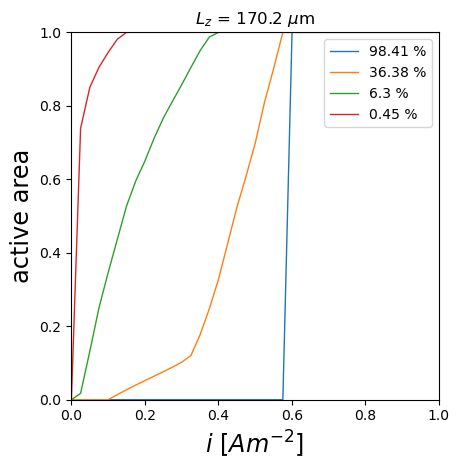

In [13]:
limits = {
    1: [40, 65],
    5: [0, 15],
    50: [0, 1.5],
    100: [0, 1.0],
    200: [0, 1.0],
}
for Lz in [1, 5, 50, 100]:
    fig, ax = plt.subplots()
    for img_id in [6, 11, 16, 22]:
        data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf.csv")
        df = pd.read_csv(data_path)
        ax.plot(df['i [A/m2]'], df['p_right'], label=f'{areas[img_id]} %', linewidth=1)
    
    ax.set_xlabel(r'$i$ $[Am^{-2}]$', fontdict={'fontsize': 'xx-large'})
    ax.set_ylabel('active area', fontdict={'fontsize': 'xx-large'})
    ax.set_title(f'$L_z$ = {800/470 * Lz:.1f} $\mu$m')
    ax.set_box_aspect(1)
    ax.set_ylim([0, 1])
    ax.set_xlim(limits[Lz])
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'figures/study_2_cdf_{Lz}r.png', dpi=1200)
    plt.close()

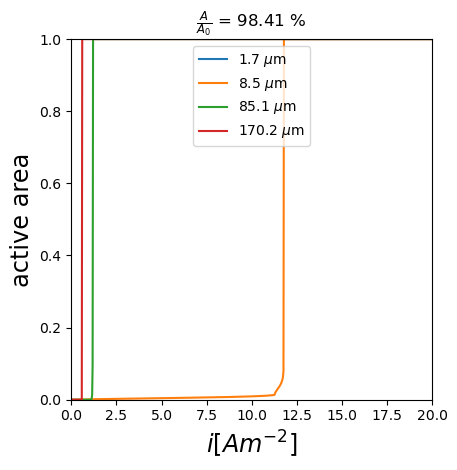

In [17]:
limits_id = {
    6: [0, 20],
    11: [0, 20],
    16: [0, 10],
    22: [0, 1.5],
}

for img_id in [6, 11, 16, 22]:
    fig, ax = plt.subplots()
    for Lz in [1, 5, 50, 100]:
        data_path = os.path.join(f"mesh/study_2/test{img_id}/470-470-{Lz}_000-000-000/", "cdf.csv")
        df = pd.read_csv(data_path)
        ax.plot(df['i [A/m2]'], df['p_right'], label=f'{800/470*Lz:.1f} $\mu$m')

    ax.set_xlabel('$i [Am^{-2}]$', fontdict={'fontsize': 'xx-large'})
    ax.set_ylabel('active area', fontdict={'fontsize': 'xx-large'})
    ax.set_title(r"$\frac{A}{A_0}$ = " + f"{areas[img_id]} %")
    ax.set_box_aspect(1)
    ax.set_ylim([0, 1])
    ax.set_xlim(limits_id[img_id])
    ax.legend(loc='upper center')
    plt.tight_layout()
    plt.savefig(f'figures/study_2_cdf-id{img_id}r.png', dpi=1200)
    plt.close()

In [ ]:
fig, ax = plt.subplots()
img = plt.imread('/home/molel/OneDrive/PhD/Data/Current_constriction/test6.tif')
ax.imshow(img[:, :, 0])
ax.set_box_aspect(1)
plt.tight_layout()
plt.savefig('figures/test6.png', dpi=1200)

## Contact Resistance

In [4]:
A0 = 800e-6 ** 2  # m2
kappa = 0.1  # S/m

df = pd.read_excel('data/study_2_scaled.xlsx', sheet_name=['hi-res'])['hi-res']
df['area_fraction'] = np.around(df['area_fraction'], 4)
df['resistance [ohm]'] = (df['Lz [um]'] * 1e-6 / A0 / kappa) / df['effective_conductivity_ratio']
lengths = [1.702128, 8.5106, 85.1064, 170.2128, 340.4256]

In [6]:
area_fractions = [0.0045, 0.0630, 0.3638, 0.9841, 1.000]

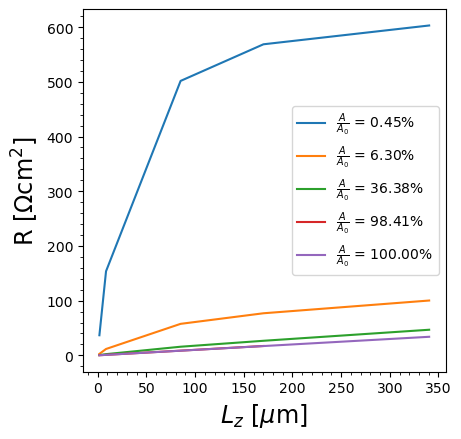

In [7]:
fig, ax = plt.subplots(figsize=(5, 4.5))
for af in area_fractions:
    df2 = df.loc[np.isclose(df['area_fraction'], af), :]
    ax.plot(df2['Lz [um]'], df2['resistance [ohm]'] * 0.64e-2, label=r"$\frac{A}{A_0}$" + f" = {100 * af:.2f}%")
ax.legend();
ax.set_xlabel(f'$L_z$ [$\mu$m]', fontdict={'fontsize': 'xx-large'});
ax.set_ylabel(r'R [$\Omega \mathrm{cm}^2$]', fontdict={'fontsize': 'xx-large'});
ax.minorticks_on();
ax.set_box_aspect(1);
plt.tight_layout();
plt.savefig('figures/variable-length-comparison.png', dpi=1200)

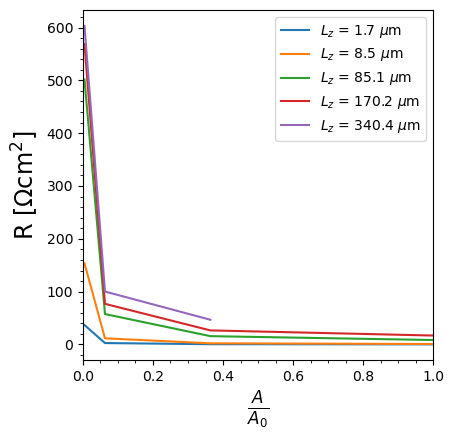

In [8]:
fig, ax = plt.subplots(figsize=(5, 4.5))
for lt in lengths:
    df2 = df.loc[np.isclose(df['Lz [um]'], lt), :]
    ax.plot(df2['area_fraction'], df2['resistance [ohm]'] * 0.64e-2, label=r"$L_z$" + f" = {lt:.1f} $\mu$m")
ax.legend();
ax.set_xlabel(r'$\frac{A}{A_0}$', fontdict={'fontsize': 'xx-large'});
ax.set_ylabel(r'R [$\Omega \mathrm{cm}^2$]', fontdict={'fontsize': 'xx-large'});
ax.set_xlim([0, 1]);
ax.set_box_aspect(1);
ax.minorticks_on();
plt.tight_layout();
plt.savefig('figures/variable-area-comparison.png', dpi=1200)

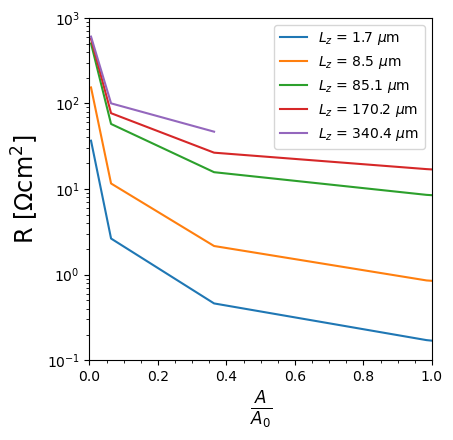

In [30]:
fig, ax = plt.subplots(figsize=(5, 4.5))
for lt in lengths:
    df2 = df.loc[np.isclose(df['Lz [um]'], lt), :]
    ax.semilogy(df2['area_fraction'], df2['resistance [ohm]'] * 0.64e-2, label=r"$L_z$" + f" = {lt:.1f} $\mu$m")
ax.legend();
ax.set_xlabel(r'$\frac{A}{A_0}$', fontdict={'fontsize': 'xx-large'});
ax.set_ylabel(r'R [$\Omega \mathrm{cm}^2$]', fontdict={'fontsize': 'xx-large'});
ax.set_xlim([0, 1]);
ax.set_ylim([1e-1, 1e3]);
ax.set_box_aspect(1);
ax.minorticks_on();
plt.tight_layout();
plt.savefig('figures/variable-area-comparison-semilog.png', dpi=1200)

In [ ]:
df.tail()

In [ ]:
fig, ax = plt.subplots(2, 2)
for i, idx in enumerate([6, 11, 16, 22]):
    img = plt.imread(f'data/current_constriction/test{idx}.tif')[:, :, 0]
    ax[int(i/2), i % 2].imshow(img, cmap='gray')
    ax[int(i/2), i % 2].title.set_text(r"$\frac{A}{A_0}$ = " + f"{areas[idx]} %")
    ax[int(i/2), i % 2].title.set_color('blue')
    ax[int(i/2), i % 2].set_xticks([])
    ax[int(i/2), i % 2].set_yticks([])
plt.tight_layout()
fig.suptitle("black " + r"$\to$" + " contact lost", color='red')
plt.savefig('figures/contact-area-maps.png', dpi=1200)

In [31]:
df2 = df.loc[np.isclose(df['Lz [um]'], 1.702128)]
df3 = df.loc[np.isclose(df['Lz [um]'], 170.212766)]

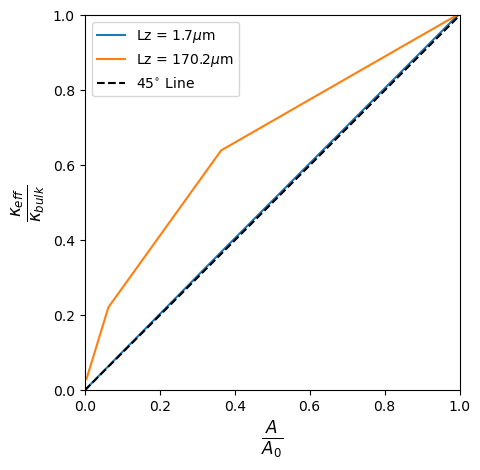

In [32]:
fig, ax = plt.subplots()
ax.plot(df2['area_fraction'], df2['effective_conductivity_ratio'], label='Lz = 1.7$\mu$m');
ax.plot(df3['area_fraction'], df3['effective_conductivity_ratio'], label='Lz = 170.2$\mu$m');
ax.set_xlim([0, 1]);
ax.set_ylim([0, 1]);
ax.set_box_aspect(1);
ax.plot([0, 1], [0, 1], '--', color='k', label='45$^{\circ}$ Line');
ax.legend();
ax.set_xlabel(r'$\frac{A}{A_0}$', fontdict={'fontsize': 'xx-large'});
ax.set_ylabel(r'$\frac{\kappa_{eff}}{\kappa_{bulk}}$', fontdict={'fontsize': 'xx-large'});
plt.tight_layout();
plt.savefig('figures/short-limit-effective-conductivity-ratio.png', dpi=1200);

In [ ]:
fig, ax = plt.subplots()
ax.plot(df3['area_fraction'], df3['effective_conductivity_ratio'], label='Lz = 170.2$\mu$m');
ax.set_xlim([0, 1]);
ax.set_ylim([0, 1]);
ax.set_box_aspect(1);
ax.plot([0, 1], [0, 1], '--', color='k', label='45$^{\circ}$ Line');
ax.legend()
ax.set_xlabel(r'$\frac{A}{A_0}$', fontdict={'fontsize': 'xx-large'})
ax.set_ylabel(r'$\frac{\kappa_{eff}}{\kappa_{bulk}}$', fontdict={'fontsize': 'xx-large'})
plt.tight_layout();
plt.savefig('figures/long-limit-effective-conductivity-ratio.png', dpi=1200)

In [ ]:
1/(4 * 0.1 * 27e-6)